https://colab.research.google.com/drive/1sjcq7zdNa_5mDs1J2hRhPj2iwYuyY7CG?usp=sharing


# COMP 4331 Tutorial 5: Naive Bayes Classifier
* Build the classifier by yourself
* Use the built-in naive Bayes classifier in **scikit-learn**
* by `Weisen Jiang`[wjiangar@connect.ust.hk]

In [13]:
import seaborn as sns
import numpy as np

import pandas as pd
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', -1)

import warnings
warnings.filterwarnings('ignore')

## prepare the data

In Windows, you may download the dataset from [this_link](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data), and place the downloaded file(`breast-cancer.data`) in your working directory.

In [14]:
# ![ -e breast-cancer.data ] && rm breast-cancer.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data

--2021-11-03 20:38:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18654 (18K) [application/x-httpd-php]
Saving to: 'breast-cancer.data.2'

     0K .......... ........                                   100% 81.0K=0.2s

2021-11-03 20:38:31 (81.0 KB/s) - 'breast-cancer.data.2' saved [18654/18654]



In [15]:
data_file = "breast-cancer.data"

# attribute names
col_names = ["class", "age", "menopause", "tumor-size", "inv-nodes", "node-caps", "deg-malign", "breast", "breast-quad", "irradiat"]

data_df = pd.read_csv(data_file, sep=',', names=col_names)


In [16]:
data_df

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malign,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


## First impression

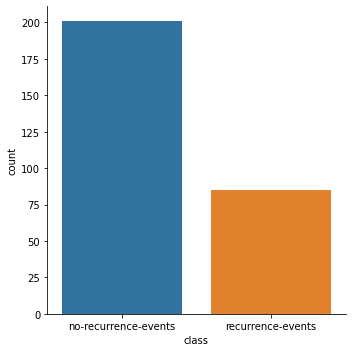

In [17]:
sns.catplot(data=data_df, x="class", kind="count");

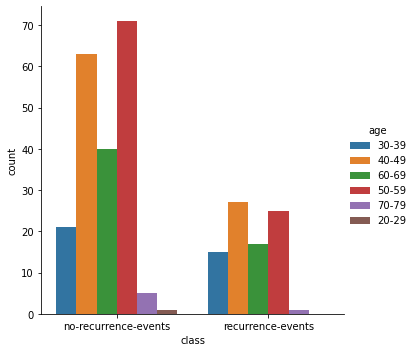

In [18]:
sns.catplot(data=data_df, x="class", hue="age", kind="count");


## Basic summary for naive Bayes classifier

putting values into dictionaries

and computing prior and conditional probabilities


In [19]:
# class_name -> count
class_stat_dict = {} 
# (class_name, attribute_name, attribute_value) -> count
attribute_stat_dict = {}
# attribute_name -> value set (for Laplace correction)
attribute_distinct_dict = {}


for i, row in data_df.iterrows():       #iters through all samples
    class_name = row["class"]           #class name

    # for p(c_i)
    current_number = class_stat_dict.get(class_name, 0)
    class_stat_dict[class_name] = current_number + 1

    for attribute in col_names[1:]:
        attribute_value = row[attribute]

        # for Laplacian smooth
        if attribute not in attribute_distinct_dict:
            attribute_distinct_dict[attribute] = set()
        attribute_distinct_dict[attribute].add(attribute_value)

        # for P(X_k | C_i)
        attribute_key = (class_name, attribute, attribute_value)
        current_number = attribute_stat_dict.get(attribute_key, 0)
        attribute_stat_dict[attribute_key] = current_number + 1  

In [20]:
class_stat_dict

{'no-recurrence-events': 201, 'recurrence-events': 85}

In [21]:
attribute_stat_dict

{('no-recurrence-events', 'age', '30-39'): 21,
 ('no-recurrence-events', 'menopause', 'premeno'): 102,
 ('no-recurrence-events', 'tumor-size', '30-34'): 35,
 ('no-recurrence-events', 'inv-nodes', '0-2'): 167,
 ('no-recurrence-events', 'node-caps', 'no'): 171,
 ('no-recurrence-events', 'deg-malign', 3): 40,
 ('no-recurrence-events', 'breast', 'left'): 103,
 ('no-recurrence-events', 'breast-quad', 'left_low'): 75,
 ('no-recurrence-events', 'irradiat', 'no'): 164,
 ('no-recurrence-events', 'age', '40-49'): 63,
 ('no-recurrence-events', 'tumor-size', '20-24'): 34,
 ('no-recurrence-events', 'deg-malign', 2): 102,
 ('no-recurrence-events', 'breast', 'right'): 98,
 ('no-recurrence-events', 'breast-quad', 'right_up'): 20,
 ('no-recurrence-events', 'age', '60-69'): 40,
 ('no-recurrence-events', 'menopause', 'ge40'): 94,
 ('no-recurrence-events', 'tumor-size', '15-19'): 23,
 ('no-recurrence-events', 'breast-quad', 'left_up'): 71,
 ('no-recurrence-events', 'tumor-size', '0-4'): 7,
 ('no-recurrenc

In [22]:
attribute_distinct_dict['age']


{'20-29', '30-39', '40-49', '50-59', '60-69', '70-79'}

# Prior Probability

In [23]:
total_num = sum(class_stat_dict.values())
for class_name in class_stat_dict:
    probability = class_stat_dict[class_name] / total_num
    print("P(class={}) = {:.4f}".format(class_name, probability))

P(class=no-recurrence-events) = 0.7028
P(class=recurrence-events) = 0.2972


# Conditional Probability

In [27]:
# for attribute_key in attribute_stat_dict:
#     class_name = attribute_key[0]
#     attribute_name = attribute_key[1]
#     attribute_value = attribute_key[2]
#     count = attribute_stat_dict[attribute_key]
#     probability = count / class_stat_dict[class_name]
#     print("P{}={} | class={})\t= {:.4f}".format(attribute_name,attribute_value,class_name))

IndexError: Replacement index 3 out of range for positional args tuple

In [28]:
for attribute_key in attribute_stat_dict:
    class_name = attribute_key[0]
    attribute_name = attribute_key[1]
    attribute_value = attribute_key[2]
    count = attribute_stat_dict[attribute_key]
    probability = count / class_stat_dict[class_name]
    print("P({}={} | class={})\t\t= {:.4f}".format(
        attribute_name, attribute_value, class_name, probability))

P(age=30-39 | class=no-recurrence-events)		= 0.1045
P(menopause=premeno | class=no-recurrence-events)		= 0.5075
P(tumor-size=30-34 | class=no-recurrence-events)		= 0.1741
P(inv-nodes=0-2 | class=no-recurrence-events)		= 0.8308
P(node-caps=no | class=no-recurrence-events)		= 0.8507
P(deg-malign=3 | class=no-recurrence-events)		= 0.1990
P(breast=left | class=no-recurrence-events)		= 0.5124
P(breast-quad=left_low | class=no-recurrence-events)		= 0.3731
P(irradiat=no | class=no-recurrence-events)		= 0.8159
P(age=40-49 | class=no-recurrence-events)		= 0.3134
P(tumor-size=20-24 | class=no-recurrence-events)		= 0.1692
P(deg-malign=2 | class=no-recurrence-events)		= 0.5075
P(breast=right | class=no-recurrence-events)		= 0.4876
P(breast-quad=right_up | class=no-recurrence-events)		= 0.0995
P(age=60-69 | class=no-recurrence-events)		= 0.1990
P(menopause=ge40 | class=no-recurrence-events)		= 0.4677
P(tumor-size=15-19 | class=no-recurrence-events)		= 0.1144
P(breast-quad=left_up | class=no-recurre

In [29]:
class_names = ["no-recurrence-events", "recurrence-events"]
alpha = 1 # Laplace correction
total_num = sum(class_stat_dict.values())
def predict(row):
    probabilities = []
    for class_name in class_names:
        
        prior_prob = class_stat_dict[class_name] / total_num
        
        likelihood = 1.0 # init
        for attribute in col_names[1:]:
            attribute_key = (class_name, attribute, row[attribute])
            numerator = attribute_stat_dict.get(attribute_key, 0) + alpha
            denominator = class_stat_dict[class_name] + len(attribute_distinct_dict[attribute])
            likelihood = likelihood * numerator / denominator
            
        probabilities.append(prior_prob*likelihood)
        
    return class_names[np.argmax(probabilities)]

In [30]:
data_df["prediction_nb_manual"] = data_df.apply(predict, axis=1)

In [31]:
data_df.head(10)

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malign,breast,breast-quad,irradiat,prediction_nb_manual
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no,recurrence-events
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no,no-recurrence-events
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no,no-recurrence-events
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no,no-recurrence-events
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no,no-recurrence-events
5,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,left,left_low,no,no-recurrence-events
6,no-recurrence-events,50-59,premeno,25-29,0-2,no,2,left,left_low,no,no-recurrence-events
7,no-recurrence-events,60-69,ge40,20-24,0-2,no,1,left,left_low,no,no-recurrence-events
8,no-recurrence-events,40-49,premeno,50-54,0-2,no,2,left,left_low,no,no-recurrence-events
9,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,left_up,no,no-recurrence-events


In [32]:
# accuracy
acc = sum(data_df["class"] == data_df["prediction_nb_manual"]) / len(data_df)
print("acc={:.2f}%".format(acc*100))

acc=75.52%


## Build naive Bayes classifier using scikit-learn

In [33]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(dtype=int)
enc.fit(data_df[col_names])

OrdinalEncoder(dtype=<class 'int'>)

encode dataframe to numpy array, an input format of naive bayes in sklearn

In [34]:
data_np = enc.transform(data_df[col_names])

In [35]:
data_np

array([[0, 1, 2, ..., 0, 2, 0],
       [0, 2, 2, ..., 1, 5, 0],
       [0, 2, 2, ..., 0, 2, 0],
       ...,
       [1, 4, 0, ..., 1, 3, 0],
       [1, 2, 0, ..., 0, 2, 0],
       [1, 3, 0, ..., 0, 2, 0]])

NameError: name 'f' is not defined

In [37]:
y = data_np[:,0] 
X = data_np[:,1:]

In [41]:
X

array([[1, 2, 5, ..., 0, 2, 0],
       [2, 2, 3, ..., 1, 5, 0],
       [2, 2, 3, ..., 0, 2, 0],
       ...,
       [4, 0, 3, ..., 1, 3, 0],
       [2, 0, 5, ..., 0, 2, 0],
       [3, 0, 5, ..., 0, 2, 0]])

train the naive bayes

In [ ]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB(alpha=1) # laplace correction
clf.fit(X, y)

CategoricalNB(alpha=1)

make prediction

In [ ]:
y_pred = clf.predict(X)

In [ ]:
acc = sum(y_pred == y) / len(y)
print("acc={:.2f}%".format(acc*100))

acc=75.52%


In [ ]:
# transform back to label name

class_names = np.array(["no-recurrence-events", "recurrence-events"])

In [ ]:
data_df["prediction_nb_sklearn"] = class_names[y_pred]

In [ ]:
data_df[["class", "prediction_nb_manual", "prediction_nb_sklearn"]].head(10)

,class,prediction_nb_manual,prediction_nb_sklearn
0,no-recurrence-events,recurrence-events,recurrence-events
1,no-recurrence-events,no-recurrence-events,no-recurrence-events
2,no-recurrence-events,no-recurrence-events,no-recurrence-events
3,no-recurrence-events,no-recurrence-events,no-recurrence-events
4,no-recurrence-events,no-recurrence-events,no-recurrence-events
5,no-recurrence-events,no-recurrence-events,no-recurrence-events
6,no-recurrence-events,no-recurrence-events,no-recurrence-events
7,no-recurrence-events,no-recurrence-events,no-recurrence-events
8,no-recurrence-events,no-recurrence-events,no-recurrence-events
9,no-recurrence-events,no-recurrence-events,no-recurrence-events


## train test split

In [ ]:
y = data_np[:,0]
X = data_np[:,1:]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB(alpha=1)
clf.fit(X_train, y_train)

CategoricalNB(alpha=1)

In [ ]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [ ]:
train_acc = sum(y_train_pred == y_train) / len(y_train)
test_acc = sum(y_test_pred == y_test) / len(y_test)

In [ ]:
print("train acc: {:.2f}%; test acc: {:.2f}%".format(train_acc*100, test_acc*100))

train acc: 76.00%; test acc: 70.93%


## try no Laplace correction

In [ ]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB(alpha=0) # no Laplace correction
clf.fit(X_train, y_train)

CategoricalNB(alpha=0)

In [ ]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
train_acc = sum(y_train_pred == y_train) / len(y_train)
test_acc = sum(y_test_pred == y_test) / len(y_test)
print("train acc: {:.2f}%; test acc: {:.2f}%".format(train_acc*100, test_acc*100))

train acc: 77.50%; test acc: 68.60%
